# Trees in Each Park

This notebook will help you discover using data which park in Strathcona County has the most trees.

Set up is done below, starting with downloading data sets directly from the Strathcona open data site. There are also some minor transformations which complicate things a little further. 

In [ ]:
#!pip install shapely
#!pip install geopandas
#!pip install spaghetti
#!pip install rtree

## on colab: 
#!apt-get install libspatialindex-dev

In [1]:
import geopandas as gpd
import pandas as pd 
import ast
import shapely
from shapely.wkt import loads
from shapely.geometry import Polygon, Point, MultiPolygon
import matplotlib.pyplot as plt

trees = pd.read_csv('https://data.strathcona.ca/api/views/v78i-7ntw/rows.csv?accessType=DOWNLOAD', converters={"Location": ast.literal_eval})
trees[['y_coord', 'x_coord']] =  pd.DataFrame(trees['Location'].tolist(), index=trees.index)
shape = pd.read_csv('https://data.strathcona.ca/api/views/m5yx-gw6e/rows.csv?accessType=DOWNLOAD')


In [2]:

small_shape = gpd.GeoDataFrame(shape[['Park_Name', 'the_geom']])
small_shape['the_geom'] = small_shape['the_geom'].apply(loads).copy()
#shape['geometry'] = shape['the_geom'].apply(loads)
trees = gpd.GeoDataFrame(trees, geometry=gpd.points_from_xy(trees.x_coord, trees.y_coord))
ss = pd.DataFrame(small_shape)
ss.rename(columns={'the_geom':'geometry'}, inplace=True)

# Maps
Makes sense to plot the data for the students - even if they don't do anything i think this adds another level to it. I do note that plotting the trees will be... well i wouldn't recommend it in terms of clobbering RAC. But even with the shape files it's interesting to see how spread out the parks are, and also all the green space that is decidedly _not_ a park. I think this is beyond what we would ask students to do because there's not really any "learning" to be done here outside of reading some dry-dry documentation. 

In [3]:
# Slap them parks on folium to see where them parks are 
import folium
maploc = folium.Map(location=[53.5701,-113.0741],zoom_start=11)
frame = gpd.GeoDataFrame(ss, geometry='geometry',crs={'init': 'epsg:4326'})
tools = folium.features.GeoJsonTooltip(fields=['Park_Name'], aliases = ["Park name: "])
folium.features.GeoJson(frame, tooltip = tools).add_to(maploc)

maploc

## Recommendation 

Seeing as it's pretty hairy to get to this point in terms of the transformations required, I think we should start with the data set spit out here. I also note that only about half the trees are in parks (and that's okay - good potential question)

That said... this isn't the worst, the problem is I think the concept of the `sjoin` with geopandas looking if a point is in a shape file is likely too abstract for a two hour hacakathon, and I would argue not that important. 

In [4]:
from geopandas.tools import sjoin
# this is doing a join that checks which park a tree lands in between both the frames
trees_parks = sjoin(trees, gpd.GeoDataFrame(ss), how='left')
trees_parks.head()

TreeSiteID          Name                               Location    y_coord  \
0        7921     Green Ash   (53.5373707290707, -113.24900125457)  53.537371   
1       34359    Amur Maple  (53.5590600201247, -113.257868914842)  53.559060   
2       33246  American Elm  (53.5419575126437, -113.324222562858)  53.541958   
3       32382     Larch spp  (53.5569543121851, -113.261950656599)  53.556954   
4       17587    Spruce spp  (53.5299142857439, -113.320350800673)  53.529914   

      x_coord                     geometry  index_right  \
0 -113.249001  POINT (-113.24900 53.53737)          NaN   
1 -113.257869  POINT (-113.25787 53.55906)        116.0   
2 -113.324223  POINT (-113.32422 53.54196)          NaN   
3 -113.261951  POINT (-113.26195 53.55695)        114.0   
4 -113.320351  POINT (-113.32035 53.52991)          NaN   

                 Park_Name  
0                      NaN  
1  Summerwood Urban Forest  
2                      NaN  
3            Suncrest Park  
4                      NaN

# Plotting Trees in Each Park

This is a little tricky to get to - This might not be something we get the students to do 

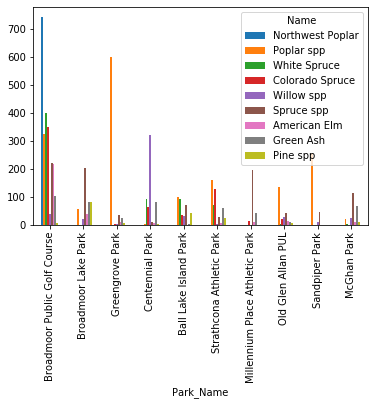

In [5]:
group = trees_parks.groupby(['Park_Name', 'Name']).count().sort_values(by='y_coord', ascending=False)
x = trees_parks.groupby(['Park_Name']).count().sort_values(by='y_coord', ascending=False)
df = group['geometry'].unstack().reset_index().set_index("Park_Name")
df = df[df.columns[df.sum()>500]]
df.loc[x.index][:10].plot(kind='bar')

# Park with highest density of trees
This one actually isn't too hard to do - the hard part is you need to change the projection from lat/long to cartesian so area returns square meters instead of angular area. 

In [6]:
#trees_parks.crs = {'init': 'epsg:3857'}
#trees_parks['area'] = trees_parks['geometry'].area
a = gpd.GeoDataFrame(ss, crs={'init': 'epsg:4326'})

a['area'] = a.to_crs({'init': 'epsg:3857'})['geometry'].area 

trees_w_area =sjoin(trees, gpd.GeoDataFrame(a), how='left')
trees_w_area.head()

TreeSiteID          Name                               Location    y_coord  \
0        7921     Green Ash   (53.5373707290707, -113.24900125457)  53.537371   
1       34359    Amur Maple  (53.5590600201247, -113.257868914842)  53.559060   
2       33246  American Elm  (53.5419575126437, -113.324222562858)  53.541958   
3       32382     Larch spp  (53.5569543121851, -113.261950656599)  53.556954   
4       17587    Spruce spp  (53.5299142857439, -113.320350800673)  53.529914   

      x_coord                     geometry  index_right  \
0 -113.249001  POINT (-113.24900 53.53737)          NaN   
1 -113.257869  POINT (-113.25787 53.55906)        116.0   
2 -113.324223  POINT (-113.32422 53.54196)          NaN   
3 -113.261951  POINT (-113.26195 53.55695)        114.0   
4 -113.320351  POINT (-113.32035 53.52991)          NaN   

                 Park_Name           area  
0                      NaN            NaN  
1  Summerwood Urban Forest  168516.256476  
2                      NaN            NaN  
3            Suncrest Park   23818.505244  
4                      NaN            NaN

# Area Plot/ Challenge Question


I think this should be reasonable to get the students to do provided we give them area and tell them the units, we will need to find a smoother merge (certainly a join will probably do - I just haven't done it here). But regardless it's a reasonable challenge question as it has two steps:

1. Join/merge the data appropriately (we may want to skip this step)
2. create a new column which is the ratio of the number of trees/unit of area
    - May also need a unit conversion
3. Plot it 
4. and ideally, compare the "tree density" plot to the the strict number of trees. 
5. From there we could get the students to tell us their opinion on the best parks based on trees/density of trees 

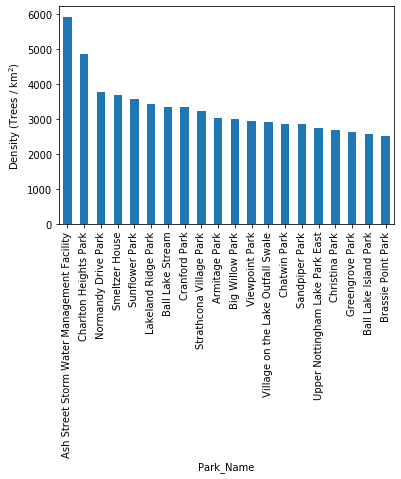

In [7]:
x = trees_parks.groupby("Park_Name").count().reset_index()[["Park_Name", "Location"]]
# Probably a easier join 
x2 = pd.merge(trees_w_area[['Park_Name', 'area']], x, on = "Park_Name").drop_duplicates(subset="Park_Name")
x2['density'] = x2['Location'] / (x2['area']/1e6)
x2=x2.set_index("Park_Name")
ax = x2.sort_values('density', ascending=False)['density'][:20].plot(kind='bar')
ax.set_ylabel("Density (Trees / km$^2$)")
plt.show()